# Journal of Neurotrauma Extraction Code

In [8]:
# Import Statements
import os
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import json
from math import ceil
from collections import defaultdict, Counter
from statistics import mean, median, stdev
import matplotlib.pyplot as plt

In [2]:
# List all files in the current directory
os.listdir()

['final-JNeurotrauma.ipynb',
 '.DS_Store',
 'README.md',
 '.ipynb_checkpoints',
 '.git',
 'Data']

## PMID to PMCID Conversion

In [3]:
# Count number of PMIDs in pmid-JNeurotrau-set.txt
with open('Data/pmid-JNeurotrau-set.txt', 'r') as file:
    pmid_lines = file.readlines()
    number_of_pmids = len(pmid_lines)

print(f"Number of PMIDs: {number_of_pmids}")


Number of PMIDs: 1131


In [6]:
# Count number of PMCIDs in pmcid-JNeurotrau-set.txt
with open('Data/pmcid-JNeurotrau-set.txt', 'r') as file:
    pmcid_lines = file.readlines()
    number_of_pmcids = len(pmcid_lines)

print(f"Number of PMCIDs: {number_of_pmcids}")


Number of PMCIDs: 1092


In [7]:
pmid_list = [line.strip().split('-')[0] for line in pmid_lines]
pmcid_list = [line.strip().split('-')[0] for line in pmcid_lines]

# Find missing PMIDs that are in pmid-JNeurotrau-set.txt but not in pmcid-JNeurotrau-set.txt
missing_pmids = set(pmid_list) - set(pmcid_list)
number_of_missing_pmids = len(missing_pmids)
number_difference = number_of_pmids - number_of_pmcids

print(f"Number of missing PMIDs: {number_of_missing_pmids}\n")
print(f"Missing PMIDs:\n{missing_pmids}")


Number of missing PMIDs: 39

Missing PMIDs:
{'24849726', '24738754', '24949719', '20199141', '24959845', '24806994', '24936867', '24926612', '24945364', '24836936', '24811484', '24831582', '24934382', '24963966', '24955788', '24827476', '24786802', '24749541', '24797413', '24640955', '24827371', '24927383', '24742275', '21939392', '24903744', '24786364', '24735430', '24945082', '24605991', '24850066', '24731132', '24934504', '24693985', '24831774', '24945196', '24773520', '24693960', '24786666', '24588281'}


#### We can see that 39 PMIDs were not converted to PMCIDs so now we're dealing with 1092 PMCIDs or papers.

## Methods Section Extraction

In [ ]:
# Function to fetch Paper content of a given PMCID
def fetch_pmc_html(pmcid):
    url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmcid}/"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Referer': 'https://www.ncbi.nlm.nih.gov/',
    }
    try:
        response = requests.get(url, headers=headers)
        sleep(uniform(1, 3))
        if response.status_code == 200:
            return response.content
        elif response.status_code == 404:
            print(f"PMCID {pmcid} not found (404). Skipping.")
            return None
        else:
            print(f"Failed to fetch HTML for PMCID: {pmcid} - Status Code: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching HTML for PMCID: {pmcid} - Error: {e}")
        return None

# Function to extract the Methods section from Paper content
def extract_methods_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    potential_headings = ['methods', 'method', 'materials and methods', 'methodology']
    methods_sections = []

    for heading_text in potential_headings:
        methods_heading = soup.find(lambda tag: tag.name in ['h2', 'h3', 'h4'] and heading_text in tag.get_text(strip=True).lower())
        if methods_heading:
            current_element = methods_heading.find_next()
            while current_element and current_element.name in ['p', 'div', 'section']:
                if current_element.name == 'p':
                    methods_sections.append(current_element.get_text(strip=True))
                elif current_element.name == 'div' and ('sec' in current_element.get('class', []) or 'tsec' in current_element.get('class', [])):
                    methods_sections.append(current_element.get_text(separator="\n", strip=True))
                elif current_element.name == 'section':
                    methods_sections.append(current_element.get_text(separator="\n", strip=True))
                current_element = current_element.find_next_sibling()
            if methods_sections:
                break

    return "\n\n".join(methods_sections) if methods_sections else "Methods section not found."

# Function to process each PMCID
def process_pmcid(pmcid):
    html_content = fetch_pmc_html(pmcid)
    if html_content:
        methods_text = extract_methods_from_html(html_content)
        return {"PMCID": pmcid, "Methods": methods_text}, None
    return None, pmcid

# Function to save results in JSON format using the chunking strategy 
def save_json(data, file_index, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f"methods_{file_index}.json")
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)


In [23]:
def main(input_file, file_start_index=1, chunk_size=100):
    """
    Main function to process a range of PMCIDs and save results in chunks of a specified size.
    
    Args:
        input_file (str): The file containing PMCIDs in the format PMID-PMCID.
        file_start_index (int): The starting index for naming output files.
        chunk_size (int): The number of PMCIDs per output JSON file.
    """
    output_dir = 'methods-Jneurotrauma-new'
    failed_pmcids = []

    with open(input_file, 'r') as f:
        lines = f.readlines()
        pmcids = [line.strip().split('-')[1] for line in lines]

    results = []
    file_index = file_start_index
    num_chunks = ceil(len(pmcids) / chunk_size)

    # Process PMCIDs in chunks
    with ThreadPoolExecutor(max_workers=10) as executor:
        for chunk_index in range(num_chunks):
            start = chunk_index * chunk_size
            end = start + chunk_size
            chunk = pmcids[start:end]
            
            for result, failed in tqdm(executor.map(process_pmcid, chunk), total=len(chunk)):
                if result:
                    results.append(result)
                if failed:
                    failed_pmcids.append(failed)

                # Save results every chunk_size entries
                if len(results) >= chunk_size:
                    save_json(results, file_index, output_dir)
                    results = []
                    file_index += 1

            # Add randomized sleep time between each chunk
            sleep(uniform(5, 10))

    # Saving remaining in the last chunk
    if results:
        save_json(results, file_index, output_dir)

    # Save all failed PMCIDs to a file
    if failed_pmcids:
        with open(os.path.join(output_dir, 'failed_pmcids.txt'), 'a') as f:
            for pmcid in failed_pmcids:
                f.write(f"{pmcid}\n")

if __name__ == "__main__":
    main(input_file='Data/pmcid-JNeurotrau-set.txt')


## Analysis of retrieved methods section

In [13]:
with open('Data/pmcid-JNeurotrau-set.txt', 'r') as file:
    pmcid_list = [line.strip().split('-')[1] for line in file.readlines()]

json_pmcids = set()
missing_methods_pmcids = set()

# Loop through the JSON files
for i in range(1, 12):
    file_path = f'Extracted Jneurotrauma-new/methods_{i}.json'
    if os.path.exists(file_path):
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            for entry in data:
                pmcid = entry['PMCID']
                json_pmcids.add(pmcid)
                if entry['Methods'] == "Methods section not found.":
                    missing_methods_pmcids.add(pmcid)

pmcid_set = set(pmcid_list)
missing_pmcids = pmcid_set - json_pmcids

all_missing = missing_pmcids.union(missing_methods_pmcids)
print(f"Total Methods Sections extracted: {len(pmcid_set) - len(all_missing)}\n")
print(f"Total missing PMCIDs (including 'Methods section not found'): {len(all_missing)}\n")
print(f"Missing PMCIDs: {all_missing}")


Total Methods Sections extracted: 1008

Total missing PMCIDs (including 'Methods section not found'): 84

Missing PMCIDs: {'PMC10294563', 'PMC5444485', 'PMC6860001', 'PMC8820207', 'PMC7364315', 'PMC5444482', 'PMC5220558', 'PMC4677116', 'PMC9225401', 'PMC7075026', 'PMC4321975', 'PMC4651019', 'PMC8404157', 'PMC6239093', 'PMC6479246', 'PMC6354596', 'PMC5467123', 'PMC8403188', 'PMC4722574', 'PMC8390784', 'PMC6016098', 'PMC7071068', 'PMC6479251', 'PMC8404155', 'PMC9529317', 'PMC7075031', 'PMC8820834', 'PMC4677114', 'PMC5583559', 'PMC5653145', 'PMC4842943', 'PMC5653140', 'PMC7586452', 'PMC4988348', 'PMC5647496', 'PMC9122127', 'PMC5220527', 'PMC8054513', 'PMC7643768', 'PMC4700397', 'PMC10024052', 'PMC5467140', 'PMC5335782', 'PMC6306681', 'PMC7698832', 'PMC9225395', 'PMC7698848', 'PMC7045351', 'PMC5695753', 'PMC9225403', 'PMC5079409', 'PMC8349722', 'PMC8978568', 'PMC10259602', 'PMC10541939', 'PMC7757533', 'PMC9422788', 'PMC5510666', 'PMC10460697', 'PMC10150731', 'PMC5444420', 'PMC8820284', 'PM

#### We can see that out of 1092 papers, we were able to extract only 1008 methods section and 84 papers did not have any methdos section in the papers according to the extraction technique. 

## Comparison with JATS retrieval

#### Assuming JATS retrieval to be ground truth, we compare the methods extracted from both techinques to see how well this retrieval method is performing.

In [17]:
# Directories for the datasets
dir_ground_truth = 'Data/Extracted JNeurotrauma - Jats'
dir_new = 'Data/Extracted Jneurotrauma-new'

# Load ground truth data (ignoring 'none')
ground_truth_methods = {}
for filename in os.listdir(dir_ground_truth):
    if filename.endswith('.json'):
        with open(os.path.join(dir_ground_truth, filename), 'r') as file:
            file_data = json.load(file)
            for pmcid, section in file_data.items():
                if section.lower() != "none":
                    ground_truth_methods[pmcid] = section

# Load new data
new_methods = {}
for filename in os.listdir(dir_new):
    if filename.endswith('.json'):
        with open(os.path.join(dir_new, filename), 'r') as file:
            file_data = json.load(file)
            for entry in file_data:
                pmcid = entry.get('PMCID')
                methods = entry.get('Methods', 'None')
                new_methods[pmcid] = methods

# Identify matched PMCIDs and calculate statistics
matched_pmcids = set(ground_truth_methods.keys()).intersection(new_methods.keys())

# Ground Truth Statistics
ground_truth_word_counts = [len(section.split()) for pmcid, section in ground_truth_methods.items() if pmcid in matched_pmcids]
total_ground_truth_methods = len(ground_truth_word_counts)
total_words_ground_truth = sum(ground_truth_word_counts)
average_length_ground_truth = mean(ground_truth_word_counts) if ground_truth_word_counts else 0
longest_ground_truth = max(ground_truth_word_counts) if ground_truth_word_counts else 0
shortest_ground_truth = min(ground_truth_word_counts) if ground_truth_word_counts else 0

# New Methods Statistics
new_word_counts = [len(new_methods[pmcid].split()) for pmcid in matched_pmcids if new_methods[pmcid].lower() != "none"]
total_new_methods = len(new_word_counts)
total_words_new = sum(new_word_counts)
average_length_new = mean(new_word_counts) if new_word_counts else 0
longest_new = max(new_word_counts) if new_word_counts else 0
shortest_new = min(new_word_counts) if new_word_counts else 0

# Print Statistics
print(f"Statistics for Matched Subset:")
print(f"\nGround Truth (JATS):")
print(f"  Total Methods Sections: {total_ground_truth_methods}")
print(f"  Total Words in Methods: {total_words_ground_truth}")
print(f"  Average Methods Section Length: {average_length_ground_truth:.2f} words")
print(f"  Longest Methods Section: {longest_ground_truth} words")
print(f"  Shortest Methods Section: {shortest_ground_truth} words")

print(f"\nExtracted Methods (New Data):")
print(f"  Total Methods Sections: {total_new_methods}")
print(f"  Total Words in Methods: {total_words_new}")
print(f"  Average Methods Section Length: {average_length_new:.2f} words")
print(f"  Longest Methods Section: {longest_new} words")
print(f"  Shortest Methods Section: {shortest_new} words")


Statistics for Matched Subset:

Ground Truth (JATS):
  Total Methods Sections: 189
  Total Words in Methods: 302851
  Average Methods Section Length: 1602.39 words
  Longest Methods Section: 6045 words
  Shortest Methods Section: 201 words

Extracted Methods (New Data):
  Total Methods Sections: 189
  Total Words in Methods: 323030
  Average Methods Section Length: 1709.15 words
  Longest Methods Section: 6632 words
  Shortest Methods Section: 58 words


#### Calculate the difference in word count of each paper

In [15]:
# Calculate differences in word counts between matched methods sections
word_count_differences = {}

for pmcid in matched_pmcids:
    ground_truth_count = len(ground_truth_methods[pmcid].split())
    new_count = len(new_methods[pmcid].split()) if new_methods[pmcid].lower() != "none" else 0
    difference = new_count - ground_truth_count
    word_count_differences[pmcid] = difference

sorted_differences = sorted(word_count_differences.items(), key=lambda x: x[1], reverse=True)

print(f"{'PMCID':<15}{'Word Count Difference'}")
for pmcid, diff in sorted_differences:
    print(f"{pmcid:<15}{diff}")


PMCID          Word Count Difference
PMC10458377    1023
PMC10698787    863
PMC5035937     788
PMC6761596     608
PMC10294565    587
PMC6387571     582
PMC4799702     575
PMC11005383    568
PMC10698859    546
PMC11071085    461
PMC9529318     436
PMC10259607    415
PMC6964807     415
PMC10061334    414
PMC7071087     386
PMC7703399     344
PMC6306688     296
PMC6653790     286
PMC11001960    263
PMC7185329     251
PMC6098406     246
PMC5610384     243
PMC10458380    230
PMC9529303     230
PMC5784797     224
PMC6196746     199
PMC6964811     196
PMC7249477     193
PMC6157374     181
PMC11005384    180
PMC4651056     172
PMC7249480     167
PMC7826437     163
PMC5962910     159
PMC10653072    153
PMC7249468     152
PMC6964812     143
PMC5220564     138
PMC5563857     137
PMC6446209     129
PMC6306675     127
PMC7875604     126
PMC4722555     125
PMC6818492     124
PMC8126427     121
PMC6484360     120
PMC6978787     117
PMC7185350     115
PMC7462038     108
PMC5899289     105
PMC5784793  

## Transparency, Rigor, and Reproducibility Statement Extraction

In [18]:
def fetch_pmc_html(pmcid):
    """
    Fetches the HTML page for the given PMCID from PubMed Central.
    """
    url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmcid}/"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Referer': 'https://www.ncbi.nlm.nih.gov/',
    }
    try:
        response = requests.get(url, headers=headers)
        sleep(uniform(20,25))  # Sleep for 5 to 8 seconds between requests to avoid rate limiting
        if response.status_code == 200:
            return response.content
        elif response.status_code == 404:
            print(f"PMCID {pmcid} not found (404). Skipping.")
            return None
        else:
            print(f"Failed to fetch HTML for PMCID: {pmcid} - Status Code: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching HTML for PMCID: {pmcid} - Error: {e}")
        return None

def extract_transparency_section_and_year(html_content):
    """
    Parses the HTML content to extract a section containing keywords 'transparency', 'rigor', or 'reproducibility',
    and retrieves the year of the paper.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    keywords = ['transparency', 'rigor', 'reproducibility']
    transparency_section = None
    year = None

    # Find a heading that contains any of the keywords
    transparency_heading = soup.find(
        lambda tag: tag.name in ['h2', 'h3', 'h4'] and 
        any(keyword in tag.get_text(strip=True).lower() for keyword in keywords)
    )
    
    # Extract the section following the identified heading
    if transparency_heading:
        transparency_section = []
        current_element = transparency_heading.find_next()
        while current_element and current_element.name in ['p', 'div', 'section']:
            if current_element.name == 'p':
                transparency_section.append(current_element.get_text(strip=True))
            elif current_element.name == 'div' and ('sec' in current_element.get('class', []) or 'tsec' in current_element.get('class', [])):
                transparency_section.append(current_element.get_text(separator="\n", strip=True))
            elif current_element.name == 'section':
                transparency_section.append(current_element.get_text(separator="\n", strip=True))
            current_element = current_element.find_next_sibling()

    # Extracting the year of publication
    year_tag = soup.find('meta', {'name': 'citation_publication_date'})
    if year_tag and 'content' in year_tag.attrs:
        year = year_tag['content'].split('-')[0]

    # Join the extracted paragraphs into a single string or return a not found message
    return "\n\n".join(transparency_section) if transparency_section else "Section related to transparency, rigor, or reproducibility not found.", year

def process_single_pmcid(pmcid):
    """
    Processes a single PMCID to fetch HTML, extract the section, and the year.
    Returns a dictionary with PMCID, year, and the section content.
    """
    html_content = fetch_pmc_html(pmcid)
    if html_content:
        transparency_summary, publication_year = extract_transparency_section_and_year(html_content)
        return {"PMCID": pmcid, "Year": publication_year, "Section": transparency_summary}
    return {"PMCID": pmcid, "Year": None, "Section": "Failed to retrieve or process"}

def save_json(data, file_index, output_dir):
    """
    Saves the collected data into a JSON file in the specified output directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f"sections_{file_index}.json")
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved {len(data)} entries to {file_path}")

In [39]:
def main(input_file, section_number, chunk_size=100):
    """
    Main function to process a specific section of PMCIDs based on section number and save results.

    Args:
        input_file (str): The file containing PMCIDs in the format PMID-PMCID.
        section_number (int): The section number to process (1 for the first 0-99, 2 for 100-199, etc.).
        chunk_size (int): The number of PMCIDs per output JSON file.
    """
    output_dir = 'Data/Additional Section - extracted'
    failed_pmcids = []

    # Read all PMCIDs from the input file
    with open(input_file, 'r') as f:
        lines = f.readlines()
        pmcids = [line.strip().split('-')[1] for line in lines]

    # Calculate start and end indices based on section number and chunk size
    start_index = (section_number - 1) * chunk_size
    end_index = start_index + chunk_size

    if start_index >= len(pmcids):
        print("Start index exceeds the total number of PMCIDs.")
        return

    pmcids_to_process = pmcids[start_index:end_index]

    results = []
    file_index = section_number

    # Process PMCIDs in chunks using multithreading
    with ThreadPoolExecutor(max_workers=12) as executor:
        futures = {executor.submit(process_single_pmcid, pmcid): pmcid for pmcid in pmcids_to_process}

        for i, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc=f"Processing Section {section_number}")):
            result = future.result()
            if result['Section'] == "Failed to retrieve or process":
                failed_pmcids.append(result['PMCID'])
            else:
                results.append(result)

    save_json(results, file_index, output_dir)

    if failed_pmcids:
        with open(os.path.join(output_dir, 'failed_pmcids.txt'), 'a') as f:
            for pmcid in failed_pmcids:
                f.write(f"{pmcid}\n")

section_number = # your section extracting
main(input_file='pmcid-JNeurotrau-set.txt', section_number=section_number, chunk_size=100)


## Analysis of additional section extraction

Total unique PMCIDs found: 1091
Total JSON entries: 1091
Entries with additional sections: 39

Yearly Summary:
Year 2014: Total Papers = 45, With Section = 1
Year 2015: Total Papers = 117, With Section = 0
Year 2016: Total Papers = 102, With Section = 0
Year 2017: Total Papers = 144, With Section = 0
Year 2018: Total Papers = 131, With Section = 0
Year 2019: Total Papers = 149, With Section = 1
Year 2020: Total Papers = 122, With Section = 2
Year 2021: Total Papers = 138, With Section = 3
Year 2022: Total Papers = 71, With Section = 3
Year 2023: Total Papers = 63, With Section = 21
Year 2024: Total Papers = 9, With Section = 8


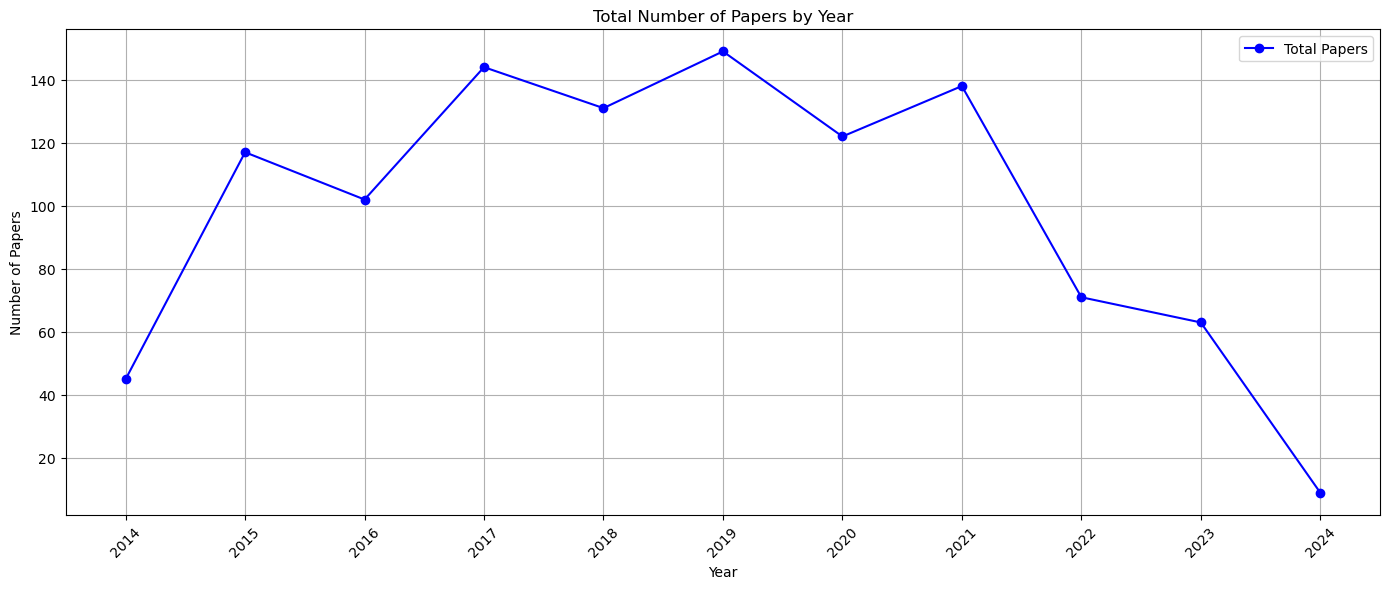

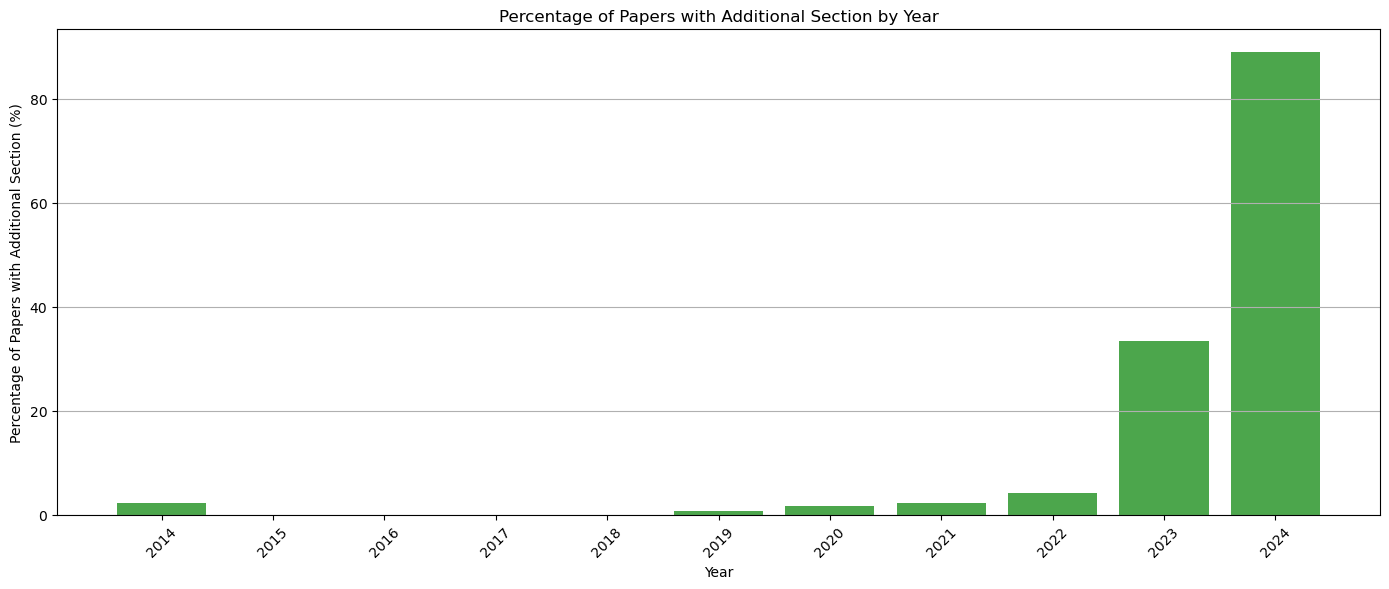

In [20]:
total_counts = defaultdict(int)
additional_section_counts = defaultdict(int)
total_entries = 0
entries_with_section = 0
pmcid_set = set()  # To track unique PMCIDs and identify duplicates

data_directory = 'Data/Additional Section - extracted'

for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(data_directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            total_entries += len(data)  # Count total entries in all JSON files
            for entry in data:
                pmcid = entry.get('PMCID', None)
                
                # Check for duplicate PMCIDs
                if pmcid in pmcid_set:
                    print(f"Duplicate PMCID found: {pmcid} in {filename}")
                else:
                    pmcid_set.add(pmcid)

                try:
                    # Extract year based on date format
                    date_str = entry['Year']
                    if any(char.isalpha() for char in date_str):
                        year = int(date_str[-4:])
                    else:
                        year = int(date_str[:4])
                    
                    # Update counts
                    total_counts[year] += 1
                    if "Section related to transparency, rigor, or reproducibility not found." not in entry['Section']:
                        additional_section_counts[year] += 1
                        entries_with_section += 1
                except ValueError:
                    print(f"Error parsing date: {date_str} in entry: {entry}")

# Validate total counts
unique_pmcid_count = len(pmcid_set)
print(f"Total unique PMCIDs found: {unique_pmcid_count}")

# Check if there's a discrepancy in counts
if total_entries != unique_pmcid_count:
    print(f"Discrepancy found! Total entries counted: {total_entries}, Unique PMCIDs: {unique_pmcid_count}")

# Prepare data for plotting
years = sorted(total_counts.keys())
total_papers = [total_counts[year] for year in years]
percent_with_section = [(additional_section_counts[year] / total_counts[year]) * 100 for year in years]

# Print summary statistics
print(f"Total JSON entries: {total_entries}")
print(f"Entries with additional sections: {entries_with_section}")
print("\nYearly Summary:")
for year in years:
    print(f"Year {year}: Total Papers = {total_counts[year]}, With Section = {additional_section_counts[year]}")

# Plot total papers by year
plt.figure(figsize=(14, 6))
plt.plot(years, total_papers, marker='o', linestyle='-', color='b', label='Total Papers')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Total Number of Papers by Year')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Plot percentage of papers with additional sections by year
plt.figure(figsize=(14, 6))
plt.bar(years, percent_with_section, color='g', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Percentage of Papers with Additional Section (%)')
plt.title('Percentage of Papers with Additional Section by Year')
plt.grid(axis='y')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()


#### Show Additional Section Extracted year by year

In [49]:
additional_section_counts = defaultdict(int)
pmcids_with_section = defaultdict(list)

# Directory containing the JSON files
data_directory = 'final-additional'

for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(data_directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            for entry in data:
                # Extract year based on date format
                date_str = entry['Year']
                pmcid = entry['PMCID']
                if any(char.isalpha() for char in date_str):
                    year = int(date_str[-4:])
                else:
                    year = int(date_str[:4])
                
                # Count papers with additional sections
                if "Section related to transparency, rigor, or reproducibility not found." not in entry['Section']:
                    additional_section_counts[year] += 1
                    pmcids_with_section[year].append(pmcid)

# Print PMCIDs with additional sections for each year
for year in sorted(pmcids_with_section.keys()):
    print(f"Year {year}: PMCIDs with additional section ({len(pmcids_with_section[year])} papers):")
    print(pmcids_with_section[year])
    print("")


Year 2014: PMCIDs with additional section (1 papers):
['PMC4238262']

Year 2019: PMCIDs with additional section (1 papers):
['PMC6444934']

Year 2020: PMCIDs with additional section (2 papers):
['PMC7249479', 'PMC7698845']

Year 2021: PMCIDs with additional section (3 papers):
['PMC8820287', 'PMC8403202', 'PMC7757533']

Year 2022: PMCIDs with additional section (3 papers):
['PMC9734017', 'PMC9734018', 'PMC9529298']

Year 2023: PMCIDs with additional section (21 papers):
['PMC10698778', 'PMC10698787', 'PMC10698859', 'PMC10653072', 'PMC10541943', 'PMC10460697', 'PMC10458380', 'PMC10541940', 'PMC10722895', 'PMC10460965', 'PMC10294566', 'PMC10294564', 'PMC10061336', 'PMC10312200', 'PMC10068676', 'PMC9986007', 'PMC9986031', 'PMC10150724', 'PMC9902045', 'PMC10162579', 'PMC10494907']

Year 2024: PMCIDs with additional section (8 papers):
['PMC11001960', 'PMC11005382', 'PMC11005384', 'PMC11005383', 'PMC10902499', 'PMC11071085', 'PMC11071087', 'PMC11071089']



In [21]:
# File path for the text file containing PMCIDs
pmcid_file = 'Data/pmcid-JNeurotrau-set.txt'

# Directory containing the JSON files
json_directory = 'Data/Additional Section - extracted'

# Load PMCIDs from the text file
with open(pmcid_file, 'r') as file:
    pmcid_list = [line.strip().split('-')[1] for line in file.readlines()]

# Convert list to a set for faster lookup
pmcid_set = set(pmcid_list)

# Initialize a set to store PMCIDs found in JSON files
json_pmcids = set()

# Loop through all JSON files in the directory
for filename in os.listdir(json_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(json_directory, filename)
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            for entry in data:
                pmcid = entry.get('PMCID')
                json_pmcids.add(pmcid)

# Calculate missing PMCIDs
missing_pmcids = pmcid_set - json_pmcids

# Output the results
print(f"Total PMCIDs in text file: {len(pmcid_set)}")
print(f"Total PMCIDs found in JSON files: {len(json_pmcids)}")
print(f"Total missing PMCIDs: {len(missing_pmcids)}")
print(f"Missing PMCIDs: {missing_pmcids}")


Total PMCIDs in text file: 1092
Total PMCIDs found in JSON files: 1091
Total missing PMCIDs: 1
Missing PMCIDs: {'PMC10541939'}


PMC10541939 under embargo status

#### Serach Query to get Additional Section for a specific PMCID

In [22]:
pmcid_to_search = input("Enter PMCID: ")

data_directory = 'Data/Additional Section - extracted'

found_section = None
pmcid_found = False

for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(data_directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            for entry in data:
                if entry['PMCID'] == pmcid_to_search:
                    pmcid_found = True
                    if entry['Section'] != "Section related to transparency, rigor, or reproducibility not found.":
                        found_section = entry['Section']
                    break
            if pmcid_found:
                break

if found_section:
    print(f"Additional Section for {pmcid_to_search}:\n{found_section}")
elif pmcid_found:
    print(f"No additional section found for PMCID: {pmcid_to_search}")
else:
    print(f"PMCID {pmcid_to_search} not found in the extracted list.")


Enter PMCID: PMC10541939
PMCID PMC10541939 not found in the extracted list.


In [ ]:
`

## Here's the Visual Summary of the Number of Extractions and output

![My Image](Data/Summary-Image.png)
